# Medical Abstract Classifier

This project implements a deep learning model to automatically classify sections of medical abstracts (e.g., Background, Methods, Results, Conclusions) using natural language processing (NLP) techniques. The model leverages token, character, and positional features to understand the structure and content of scientific texts.

The token+character+positional embedding model performed the best at 83% accuracy

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

## Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the Pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a txt filename) and returns the lines of text as a list

  Args:
   filename: string containing the target filepath.

  Returns:
   A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Our data would be best represented as a list of dictionaries

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overating and the development of obesity .\n',
   'total_lines': 11},
   ...
]
```

In [8]:
# Create function that can do this with an entire txt file
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is the validation txt
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# Turn into a data frame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df[:12]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

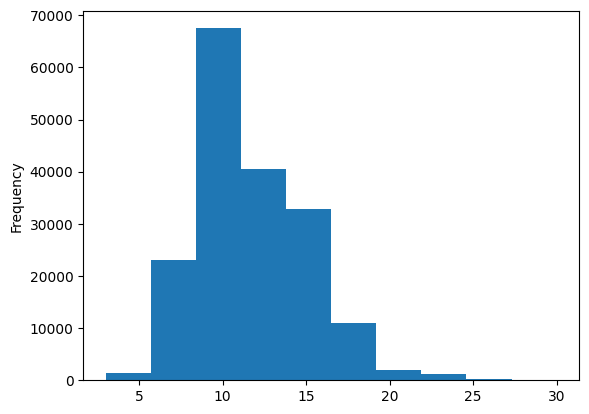

In [13]:
# Check the length of different abstracts (how many lines in each abstract)
train_df.total_lines.plot.hist()

### Get lists of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
len(train_sentences), len(val_sentences), len(test_sentences) # how many total lines in each dataset

(180040, 30212, 30135)

In [15]:
# View the first 5 lines of training dataset
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Make numeric labels (ML models require numeric labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract lables ("target" columns) and encode them into intergers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes form LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Begin modelling experiments

## Model 0: Getting a baseline (Naive Bayes)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded) # niave bayes needs an encoded labels

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, # score is the same as evaluate
                 y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make prediction using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script


In [35]:
!wget https://raw.githubusercontent.com/nithinkosanam/Medical-Abstract-Classifier/refs/heads/main/helper_functions.py

--2025-08-06 16:37:12--  https://raw.githubusercontent.com/nithinkosanam/Medical-Abstract-Classifier/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9990 (9.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.76K  --.-KB/s    in 0s      

2025-08-06 16:37:12 (115 MB/s) - ‘helper_functions.py’ saved [9990/9990]



In [36]:
from helper_functions import calculate_results

In [37]:
# Calculate baseline reuslts
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepare data for deep sequence models


In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [39]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

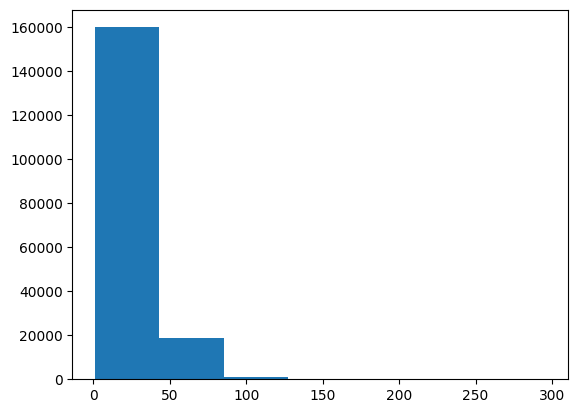

In [40]:
# View distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7)

In [41]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [42]:
# Maximum sequence length on training set
max(sent_lens)

296

### Create text vectorizer layer



In [43]:
max_tokens = 68000

In [44]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [45]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [46]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
there were no significant differences in changes in hba@c , gip , glp-@ , c-peptide , lipid profile , oxidative stress marker , inflammatory marker and egfr between the two groups .

Length of text: 32

Vectorized text:
[[  61    9   33   37  102    5  146    5  615 5663 2236 2958  864  596
  1393  401 1821  686 1821    3 1175   30    2   51   24    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [47]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [49]:
# Create token embedding layer
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [50]:
# Test embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nSentence after vectorization:\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nSentence after embedding:\n {embedded_sentence}")
embedded_sentence.shape

Sentence before vectorization:
 there were no significant differences in changes in hba@c , gip , glp-@ , c-peptide , lipid profile , oxidative stress marker , inflammatory marker and egfr between the two groups .

Sentence after vectorization:
 [[  61    9   33   37  102    5  146    5  615 5663 2236 2958  864  596
  1393  401 1821  686 1821    3 1175   30    2   51   24    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.00693111 -0.03754474  0.00032107 ... -0.00868531  0.01914091
   -0.01712259]
  [ 0.01139449 -0.02322629 -0.04453025 ... -0.04623717 -0.03784242
    0.02963909]
  [ 0.00638627 -0.0100916   0.0473222  ... -0.04349975  0.0282
   -0.03183927]
  ...
  [-0.01229364  0.04293033 -0.02275123 ... -0.0167313  -0.00128907
   -0.03837349]
  [-0.01229364  0.04293033 -0.02275123 ... -0.0167313  -0.00128907
   -0.03837349]
  [-0.01229364  0.042930

TensorShape([1, 55, 128])

## Create datasets

In [51]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [52]:
# Take the TensorSliceDataset and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [53]:
# Create 1D Conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [55]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # Validate on 10% of batches


Epoch 1/3
562/562 [==============================] - 62s 108ms/step - loss: 0.9271 - accuracy: 0.6338 - val_loss: 0.6909 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 59s 106ms/step - loss: 0.6598 - accuracy: 0.7545 - val_loss: 0.6321 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 59s 104ms/step - loss: 0.6192 - accuracy: 0.7735 - val_loss: 0.5986 - val_accuracy: 0.7856


In [56]:
# Evaluate on validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.6006 - accuracy: 0.7857


[0.6005871891975403, 0.7857142686843872]

In [57]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.3909800e-01, 1.6174854e-01, 8.5053831e-02, 2.9400980e-01,
         2.0089634e-02],
        [4.6077889e-01, 2.5716767e-01, 1.5247052e-02, 2.5683606e-01,
         9.9703465e-03],
        [1.6322556e-01, 6.2415041e-03, 1.2947166e-03, 8.2918346e-01,
         5.4750144e-05],
        ...,
        [2.7234705e-06, 6.1364053e-04, 3.9119509e-04, 2.0855562e-06,
         9.9899036e-01],
        [6.1422896e-02, 3.9403057e-01, 1.4507312e-01, 7.7929936e-02,
         3.2154357e-01],
        [1.7613235e-01, 6.9358957e-01, 3.2412704e-02, 4.4807643e-02,
         5.3057753e-02]], dtype=float32),
 (30212, 5))

In [58]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [59]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.57142857142857,
 'precision': 0.7825241238384969,
 'recall': 0.7857142857142857,
 'f1': 0.7834841231981162}

## Model 2: Feature extraction with pretrained token embeddings (USE)


In [60]:
# Download USE from TensorFlow Hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, # we're doign feature extraction, not fine tuning
                                        name="universal_sentence_encoder")

In [61]:
# Test pretrained embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"\nEmbedded sentence:\n {use_embedded_sentence[0][:30]}\n")
print(f"Shape of embedded sentence:\n {use_embedded_sentence.shape}\n")
print(f"Length of embedded sentence:\n {len(use_embedded_sentence[0])}")

Random sentence:
 results from timed functional tests and the brief pain inventory ( bpi ) were secondary endpoints .

Embedded sentence:
 [-0.02563128 -0.06376699 -0.06293698  0.03537023  0.03189463  0.05300473
 -0.01362951  0.00833069 -0.05832298  0.03565977  0.06108571 -0.04828705
 -0.00401115  0.01867131  0.02688774 -0.00471704  0.03565395  0.08402905
  0.02486952  0.05430674 -0.05536942  0.09308866 -0.04149048 -0.01751484
  0.040132   -0.07069881 -0.00488955  0.05414203 -0.07487519 -0.0108166 ]

Shape of embedded sentence:
 (1, 512)

Length of embedded sentence:
 512


### Build and fit an NPL feature extraction model using pretrained embeddings

In [62]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [64]:
# Fit model_2 to the data
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 9s 11ms/step - loss: 0.9160 - accuracy: 0.6488 - val_loss: 0.7944 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.7689 - accuracy: 0.7036 - val_loss: 0.7526 - val_accuracy: 0.7098
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7529 - accuracy: 0.7120 - val_loss: 0.7386 - val_accuracy: 0.7151


In [65]:
# Evaluate on the validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.7411 - accuracy: 0.7138


[0.7410841584205627, 0.7138223052024841]

In [66]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs



945/945 [==============================] - 7s 7ms/step


array([[4.3416554e-01, 3.6710539e-01, 1.8350251e-03, 1.8799977e-01,
        8.8942321e-03],
       [3.6143115e-01, 4.6189243e-01, 3.3580451e-03, 1.6972633e-01,
        3.5920623e-03],
       [2.2819686e-01, 1.4732260e-01, 1.7438039e-02, 5.7012910e-01,
        3.6913391e-02],
       ...,
       [1.9369501e-03, 6.3927309e-03, 5.3474966e-02, 9.0724515e-04,
        9.3728817e-01],
       [4.1382057e-03, 5.1403034e-02, 2.2182739e-01, 1.3530863e-03,
        7.2127831e-01],
       [1.7280000e-01, 2.5172624e-01, 5.0653017e-01, 7.2044609e-03,
        6.1739068e-02]], dtype=float32)

In [67]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [68]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results



{'accuracy': 71.38223222560572,
 'precision': 0.713162682312529,
 'recall': 0.7138223222560572,
 'f1': 0.7107689629714725}

# Model 3: Conv1D with character embeddings



In [69]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test
split_chars(random_train_sentence)

'r e s u l t s   f r o m   t i m e d   f u n c t i o n a l   t e s t s   a n d   t h e   b r i e f   p a i n   i n v e n t o r y   (   b p i   )   w e r e   s e c o n d a r y   e n d p o i n t s   .'

In [70]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [71]:
# Find average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

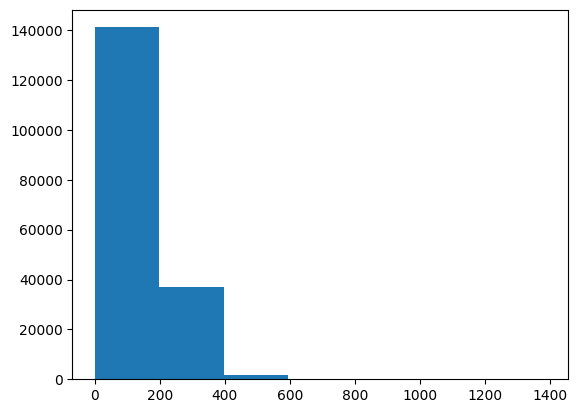

In [72]:
# Check distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [73]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [74]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [76]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t r e a t m e n t   m a y   n e e d   t o   b e   a d a p t e d   i n   t h i s   p o p u l a t i o n   .

Length of chars: 44

Vectorized chars:
[[ 3  8  2  5  3 15  2  6  3 15  5 19  6  2  2 10  3  7 22  2  5 10  5 14
   3  2 10  4  6  3 13  4  9 14  7 14 16 12  5  3  4  7  6  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  

In [77]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

# Test out character embedding
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t r e a t m e n t   m a y   n e e d   t o   b e   a d a p t e d   i n   t h i s   p o p u l a t i o n   .

Embedded chars (after vectorization and embedding):
[[[-0.04695651  0.00898954 -0.04493309 ... -0.02148883  0.00286449
    0.03947601]
  [-0.02615901  0.01453741 -0.0079571  ... -0.01387585  0.0430905
   -0.04358695]
  [-0.02518386 -0.03486734 -0.01889769 ...  0.00423431 -0.00576977
   -0.04905455]
  ...
  [-0.02327319  0.0115534  -0.00045407 ... -0.03869923  0.0258545
   -0.00211992]
  [-0.02327319  0.0115534  -0.00045407 ... -0.03869923  0.0258545
   -0.00211992]
  [-0.02327319  0.0115534  -0.00045407 ... -0.03869923  0.0258545
   -0.00211992]]]

Character embedding shape: (1, 290, 25)


### Build a Conv1D model to fit on character embeddings

In [78]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [79]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

Create char-level batched PrefetchedDataset's

In [80]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 1.2599 - accuracy: 0.4900 - val_loss: 1.0413 - val_accuracy: 0.5838
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 1.0004 - accuracy: 0.5986 - val_loss: 0.9371 - val_accuracy: 0.6257
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.9219 - accuracy: 0.6386 - val_loss: 0.8677 - val_accuracy: 0.6619


In [82]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8867 - accuracy: 0.6552


[0.8867223858833313, 0.6552363038063049]

In [83]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.17675388, 0.26032647, 0.08203477, 0.40814847, 0.07273632],
       [0.20512167, 0.45894358, 0.01715759, 0.2632298 , 0.05554731],
       [0.17656906, 0.19323698, 0.12024597, 0.49500093, 0.0149471 ],
       ...,
       [0.01904751, 0.05038612, 0.11085195, 0.03573241, 0.78398204],
       [0.01727174, 0.10908524, 0.54192793, 0.0599617 , 0.2717533 ],
       [0.3509193 , 0.5311213 , 0.03012959, 0.07167577, 0.01615398]],
      dtype=float32)

In [84]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 1])>

In [85]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.52363299351252,
 'precision': 0.6510817293627212,
 'recall': 0.6552363299351252,
 'f1': 0.6460133043734466}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token levle embedding model (similiar to `model 1`)
2. Create a character-level embedding model (similiar to `model_3`)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a  series of ouptut layers on top of 3
5. Construct a mdoel which takes token and character-level sequences as input and produced sequence label probabilies as output

In [86]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token emebdding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct final model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [87]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

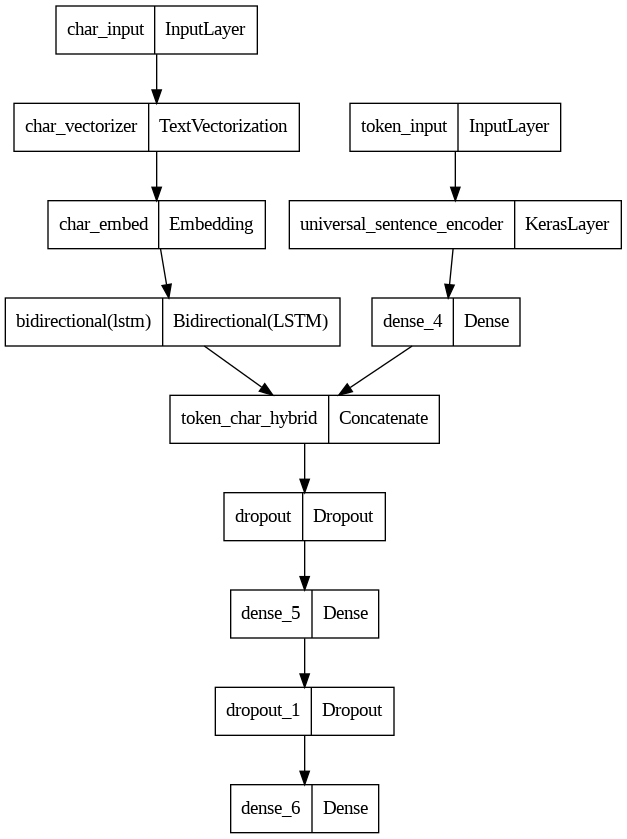

In [88]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [89]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data in a tf.Data dataset

In [90]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
# Double check shapes of the datasets
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fit model on token and character-level sequences

In [92]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 112s 190ms/step - loss: 0.9893 - accuracy: 0.6082 - val_loss: 0.7911 - val_accuracy: 0.6985
Epoch 2/3
562/562 [==============================] - 105s 187ms/step - loss: 0.8108 - accuracy: 0.6839 - val_loss: 0.7236 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 104s 184ms/step - loss: 0.7769 - accuracy: 0.7073 - val_loss: 0.7015 - val_accuracy: 0.7364


In [93]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 42s 45ms/step - loss: 0.7023 - accuracy: 0.7312


[0.7022654414176941, 0.7312326431274414]

In [94]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 43s 44ms/step


array([[4.6205199e-01, 3.2799792e-01, 4.6148011e-03, 1.9769762e-01,
        7.6377760e-03],
       [3.5382912e-01, 4.7786251e-01, 3.8805993e-03, 1.6262878e-01,
        1.7988152e-03],
       [2.9422495e-01, 2.3169993e-01, 4.4639081e-02, 3.8120762e-01,
        4.8228465e-02],
       ...,
       [5.6472258e-04, 1.2987467e-02, 3.1655796e-02, 1.4843268e-04,
        9.5464361e-01],
       [9.5636044e-03, 8.4433533e-02, 1.8254369e-01, 4.9838452e-03,
        7.1847528e-01],
       [1.5027136e-01, 3.9806390e-01, 3.8619563e-01, 2.0628188e-02,
        4.4841055e-02]], dtype=float32)

In [95]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [96]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.12326227988879,
 'precision': 0.7320386525439723,
 'recall': 0.7312326227988879,
 'f1': 0.7286311299735589}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [97]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [98]:
# Number of unique line numbers
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

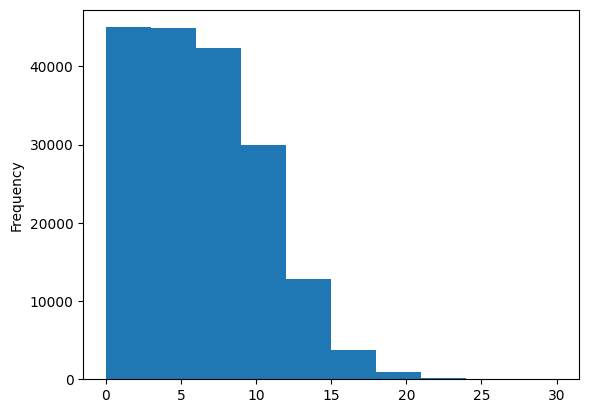

In [99]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [100]:
# One-hot encode tensors of the "line number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

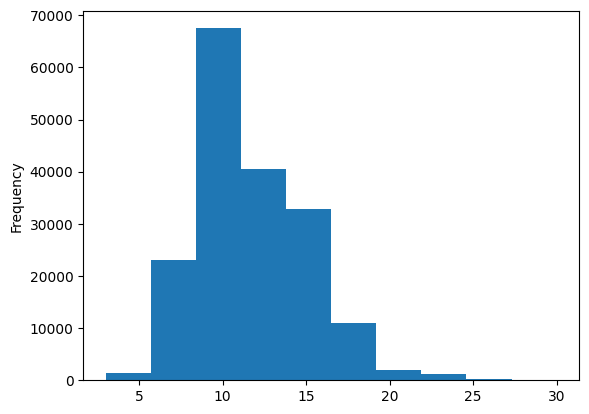

In [101]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [102]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [103]:
# One-hot encode tensors of the "total lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Build a embedding model with token+character+positional embeddings
1. Create a token level model
2. Create a character level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. CCombine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilites
8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a tf.keras.Model

In [104]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid emebedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined_embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Combine inputs and outputs into a model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input
                                 ], outputs=output_layer,
                                 name="model_5_tribrid_embedding_model")



In [105]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

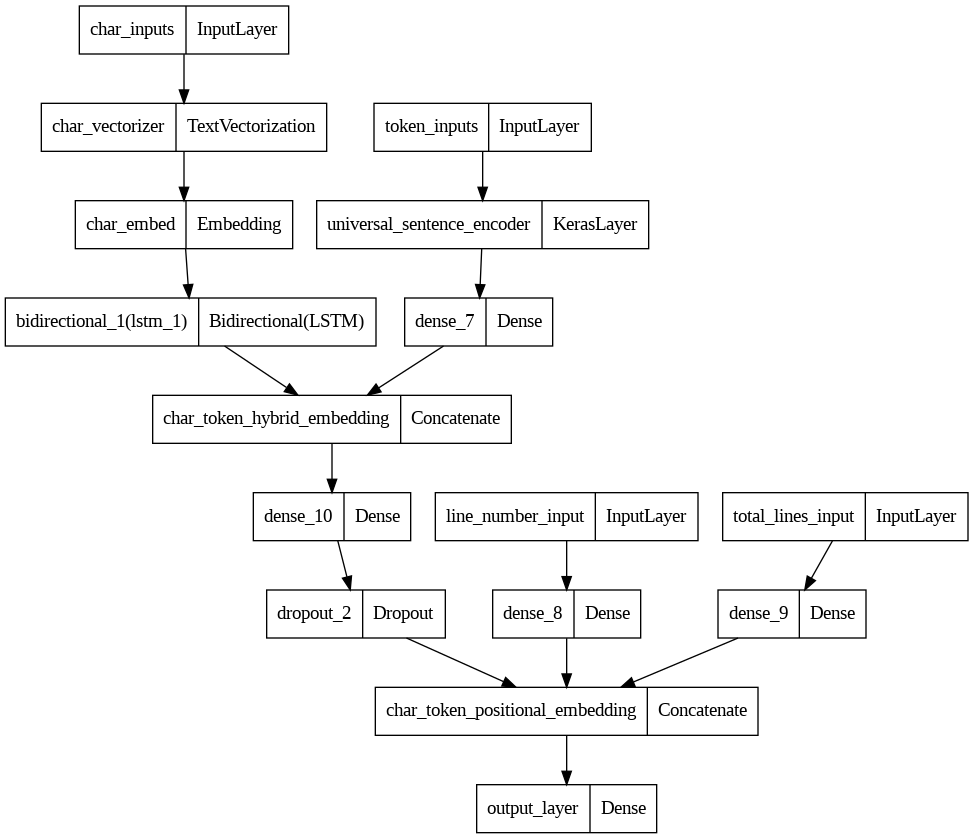

In [106]:
# View the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [107]:
# Compile
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [108]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fit, evaluate and make predictions with the model

In [109]:
# Fit
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 115s 196ms/step - loss: 1.0932 - accuracy: 0.7267 - val_loss: 0.9838 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 108s 191ms/step - loss: 0.9674 - accuracy: 0.8144 - val_loss: 0.9491 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 108s 193ms/step - loss: 0.9501 - accuracy: 0.8233 - val_loss: 0.9380 - val_accuracy: 0.8308


In [110]:
# Make predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 46s 47ms/step


array([[0.50140864, 0.11399002, 0.00938729, 0.35838333, 0.01683084],
       [0.5265834 , 0.10431585, 0.04768326, 0.31010053, 0.01131696],
       [0.2610043 , 0.11895584, 0.12770551, 0.43216476, 0.06016947],
       ...,
       [0.03494761, 0.11149076, 0.03773246, 0.0293019 , 0.7865272 ],
       [0.02654547, 0.2906732 , 0.07778877, 0.02422769, 0.58076495],
       [0.18639675, 0.58412623, 0.11180116, 0.05102695, 0.06664892]],
      dtype=float32)

In [111]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [112]:
# Calculate results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.18217926651663,
 'precision': 0.8306456919042718,
 'recall': 0.8318217926651662,
 'f1': 0.8310373478359835}

## Compare model results

In [113]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.571429,0.782524,0.785714,0.783484
pretrained_token_embed,71.382232,0.713163,0.713822,0.710769
custom_char_embed_conv1d,65.523633,0.651082,0.655236,0.646013
hybrid_char_token_embed,73.123262,0.732039,0.731233,0.728631
tribrid_pos_char_token_embed,83.182179,0.830646,0.831822,0.831037


In [114]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

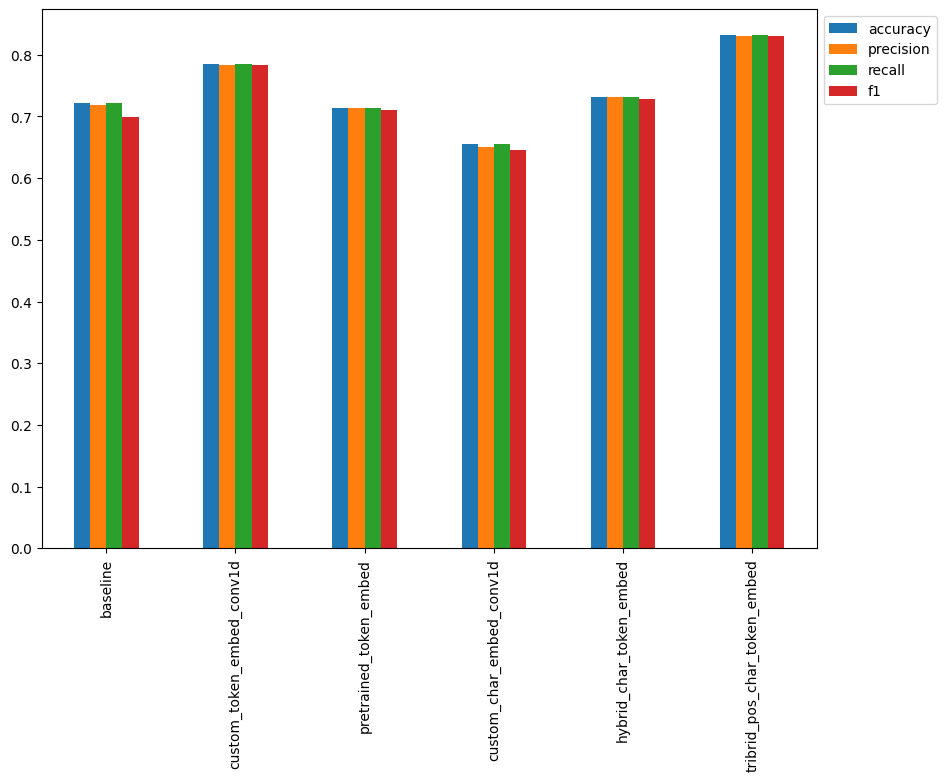

In [115]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


# The token+character+positional embedding model performed the best with an accuracy of 83%